In [3]:
!pip install torch_pca

In [4]:
# Imports
import numpy as np, matplotlib.pyplot as plt
import torch, torch_pca, gc
from torchvision import datasets, transforms
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
from PIL import Image
from tqdm import tqdm

In [5]:
# Params
SIDE_LENGTH = 128

In [9]:
# Misc. setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
# Data imports
train_transforms=transforms.Compose([
    transforms.Resize((SIDE_LENGTH, SIDE_LENGTH)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    #transforms.Grayscale(),
    transforms.ToTensor(),])

test_transforms=transforms.Compose([
    transforms.Resize((SIDE_LENGTH, SIDE_LENGTH)),
    #transforms.Grayscale(),
    transforms.ToTensor(),])

try: train_dataset = datasets.Imagenette(transform=train_transforms, size="160px", root='data', split='train', download=True)
except RuntimeError: train_dataset = datasets.Imagenette(transform=train_transforms, size="160px", root='data', split='train')
test_dataset = datasets.Imagenette(transform=test_transforms, size="160px", root='data', split='val')

In [ ]:
def channel_pca(channel_index: int, n_components: int, dtype=torch.float16, solver='randomized'):
    """Computes the pca over one channel over the training set."""
    global train_dataset, device, SIDE_LENGTH
    
    # Import the channel into a tensor
    data = torch.empty(len(train_dataset), SIDE_LENGTH, SIDE_LENGTH, dtype=dtype)
    for (i, d) in tqdm(enumerate(train_dataset), desc=f"Importing channel {channel_index}", total=len(train_dataset)):
        data[i, :, :] = torch.tensor(np.array(d[0])[channel_index, :, :].reshape(SIDE_LENGTH, SIDE_LENGTH))
    data = data.reshape(-1, SIDE_LENGTH*SIDE_LENGTH)
    data.to(device)
    gc.collect()

    # Run the PCA
    print(f"Fitting PCA on channel {channel_index} with {n_components} components, using the {solver} solver.")
    pca = torch_pca.PCA(n_components=n_components, svd_solver=solver)
    pca.fit(data)
    gc.collect()

    return pca

In [29]:
# May take a couple of minutes, depending on parameters
pcas = [channel_pca(channel, 3072) for channel in range(3)]

Importing channel 0: 100%|██████████| 9469/9469 [00:19<00:00, 492.62it/s]


Fitting PCA on channel 0 with 3072 components, using the randomized solver.


Importing channel 1: 100%|██████████| 9469/9469 [00:26<00:00, 352.71it/s]


Fitting PCA on channel 1 with 3072 components, using the randomized solver.


Importing channel 2: 100%|██████████| 9469/9469 [00:26<00:00, 358.61it/s]


Fitting PCA on channel 2 with 3072 components, using the randomized solver.


In [ ]:
# Save the PCA results as a .pt file
torch.save({
    'components0': pcas[0].components_,
    'explained_variance0': pcas[0].explained_variance_,
    'mean0': pcas[0].mean_,
    'components1': pcas[1].components_,
    'explained_variance1': pcas[1].explained_variance_,
    'mean1': pcas[1].mean_,
    'components2': pcas[2].components_,
    'explained_variance2': pcas[2].explained_variance_,
    'mean2': pcas[2].mean_,
}, f'pcas{pcas[0].n_components_}.pt')

In [30]:
def load_test_img(idx: int):
    """Returns the given test image as a torch tensor with shape (s, s, 3)."""
    global test_dataset, device
    return torch.tensor(np.array(test_dataset[idx][0]), dtype=torch.float32).permute(1, 2, 0).to(device)

def pca_project(pcas, idx: int, n=None):
    """Projects the given test image on n PCA components, or all available if `n` is unspecified."""
    global SIDE_LENGTH
    nc = pcas[0].n_components_
    n = nc if n is None else n
    p = torch.cat((torch.ones(n), torch.zeros(nc-n)), dim=0)
    sl = SIDE_LENGTH
    img = load_test_img(idx)
    tchs = [pca.inverse_transform(pca.transform(img[:, :, ch].reshape(1, -1)) * p).reshape(sl, sl, 1) for (ch, pca) in enumerate(pcas)]
    return torch.cat(tchs, dim=2)

In [31]:
def show_img(t):
    return Image.fromarray(torch.clamp(255*t.to("cpu"), 0, 255).byte().numpy())

def show_test_img(idx):
    return Image.fromarray(np.array((255*test_dataset[idx][0]).byte()).transpose((1, 2, 0)))

def normalize_gray(x: torch.Tensor):
    """Normalizes 0 to 0.5, and scales everything evenly so that all elements are in [0, 1].
    (Almost surely) either the smallest element will be 0 or the largest will be 1."""
    return 0.5 + x/(2*torch.max(torch.abs(x)))

def normalize_01(x: torch.Tensor):
    """Normalizes x so that the smallest element is 0 and the largest is 1."""
    return (x-torch.min(x))/(torch.max(x)-torch.min(x))

def get_component(pcas, idx):
    global SIDE_LENGTH
    nc = pcas[0].n_components_
    sl = SIDE_LENGTH
    if idx == -1:
        return torch.cat([(pca.mean_).reshape(sl, sl, 1) for pca in pcas], dim=2)
    p = torch.eye(nc)[idx]
    q = torch.cat([(pca.inverse_transform(p)-pca.mean_).reshape(sl, sl, 1) for pca in pcas], dim=2)
    # Attempt to align the components in sign.
    for ch in [1, 2]:
        flip = torch.sign(torch.dot(q[:, :, 0].flatten(), q[:, :, ch].flatten()))
        assert flip != 0, f"The {idx}th components for channel 0 and {ch} are orthogonal. This is extremely unlikely."
        q[:, :, ch] *= flip
    return q

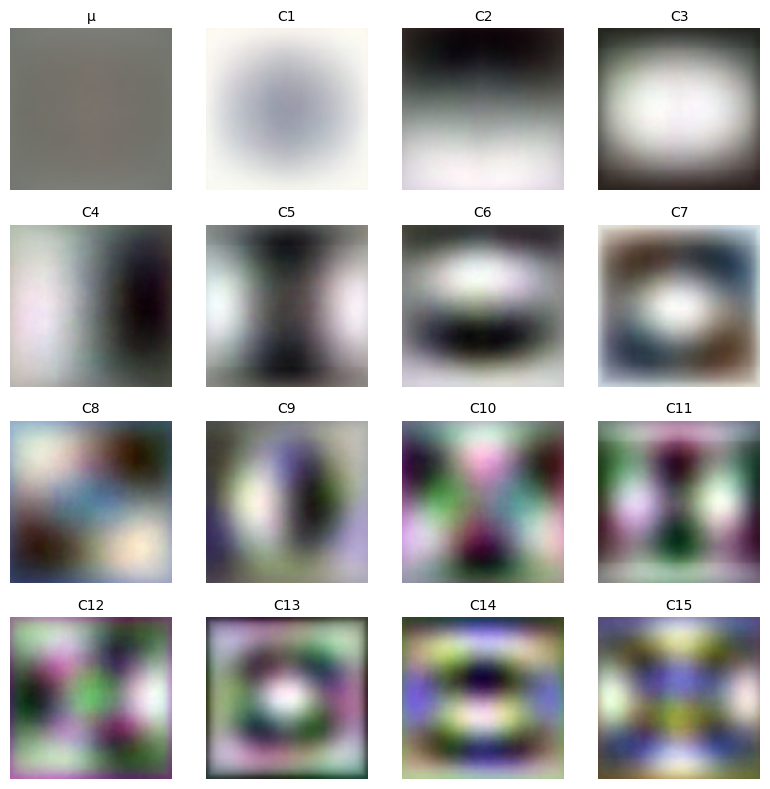

In [32]:
num_rows = 4
num_cols = 4  # Adjust based on how many images you want to plot

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))

ax = axes[0,0]
ax.imshow(show_img(get_component(pcas, -1)))
ax.axis('off')
ax.set_title('µ', fontsize=10)

for i in range(num_rows * num_cols-1):
    ax = axes[(i+1) // num_cols, (i+1) % num_cols]
    ax.imshow(show_img(normalize_gray(get_component(pcas, i))))
    ax.axis('off')
    ax.set_title(f'C{i+1}', fontsize=10)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

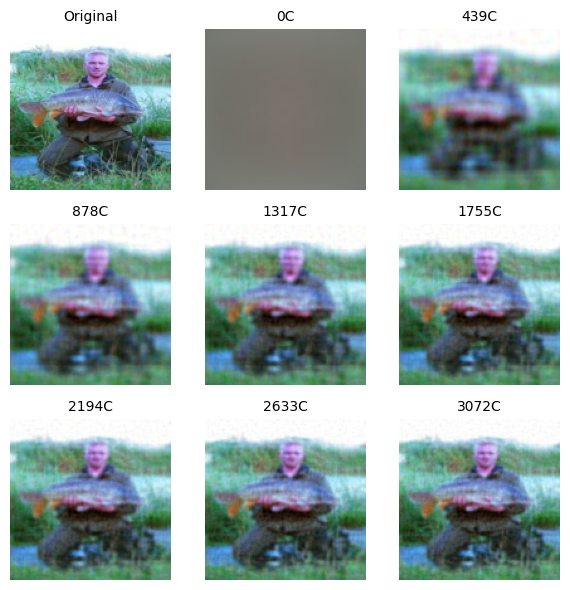

In [33]:
idx = 100
num_rows = 3
num_cols = 3  # Adjust based on how many images you want to plot
nc = pcas[0].n_components_

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(6, 6))

ax = axes[0,0]
ax.imshow(show_test_img(idx))
ax.axis('off')
ax.set_title('Original', fontsize=10)

for i in range(num_rows*num_cols-1):
    n = round(np.linspace(0, nc, num_rows*num_cols-1)[i])
    ax = axes[(i+1) // num_cols, (i+1) % num_cols]
    ax.imshow(show_img(pca_project(pcas, idx, n=n)))
    ax.axis('off')
    ax.set_title(f'{n}C', fontsize=10)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

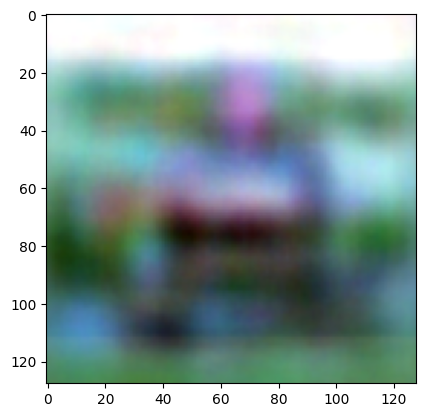

In [34]:
plt.imshow(show_img(pca_project(pcas, idx, n=100)))

In [54]:
def pca_multi_project(pcas, idx: int, components_subset=None):
    """Projects the given test image on all PCA components.
    Returns a (nc+1, s, s, 3) tensor with the [0, :, :, :] tensor representing channel-wise means,
    and [n, :, :, :] are projections on the n first components (incl. means)."""
    global SIDE_LENGTH, device
    nc = pcas[0].n_components_
    csl = nc
    sl = SIDE_LENGTH
    img = load_test_img(idx)

    with torch.no_grad():
        # Helper matrix. When BROADCAST-multiplied by x (shape (1, nc)),
        # creates an upper triangular matrix where each column contains the first elements of x
        A = torch.triu(torch.ones(nc, nc), diagonal=0)
        if components_subset is not None:
            A = A[:, components_subset]
            csl = len(components_subset)
        A.to(device)
        # Allocate output
        out = torch.zeros((csl+1, sl, sl, 3))
        # Loop over each channel
        for (ch, pca) in enumerate(pcas):
            # Get the projection on the latent space.
            x = pca.transform(img[:, :, ch].reshape(1, -1)).reshape(-1, 1) # (nc, 1). Has to have this dimension for broadcasting.
            x_mat = A * x # Upper-triangular (nc, nc)-matrix where each column contains the first elements of x
            comps = pca.components_.transpose(0, 1) # The principal components, as a (16384, nc)-matrix
            comp_projs = torch.matmul(comps, x_mat) # Projection on the first principal components. (16384, nc)
            out[1:, :, :, ch] = comp_projs.permute(1, 0).reshape(csl, sl, sl) # Unpack into output
            out[:, :, :, ch] += pca.mean_.reshape(1, sl, sl) # Add the mean to all outputs to complete the projection.
    return out

In [ ]:
# Veeery slow...
l = len(test_dataset)
nc = pcas[0].n_components_

components_subset = [0, 1, 3, 7, 15, 31, 63, 127, 255, 511, 1023, 2047]
csl = len(components_subset)

mse = np.zeros((l, csl))
ssim = np.zeros((l, csl))
psnr = np.zeros((l, csl))

# This may benefit from parallelization
# For N=100 with step 0, should take just under 1hr.
for i in tqdm(range(l)):
    original = np.array(load_test_img(i)) # (128, 128, 3)
    original_bc = np.broadcast_to(original[None, :, :, :], (csl, *original.shape)) # (nc, 128, 128, 3)
    cprojected = np.array(pca_multi_project(pcas, i, components_subset))[1:, :, :, :] # (nc, 128, 128, 3)
    mse[i, :] = np.mean(np.square(cprojected - original_bc), axis=(1,2,3))
    for n in range(len(components_subset)):
        ssim[i, n] = structural_similarity(original, cprojected[n, :, :, :], data_range=1, channel_axis=2)
        psnr[i, n] = peak_signal_noise_ratio(original, cprojected[n, :, :, :], data_range=1)

  2%|▏         | 59/3925 [00:16<18:45,  3.44it/s]

In [ ]:
torch.save({
    'components_subset': torch.tensor(components_subset),
    'mse': torch.tensor(mse),
    'ssim': torch.tensor(ssim),
    'psnr': torch.tensor(psnr)
}, 'pca_test_metrics.pt')

In [ ]:
data = torch.load('pca_test_metrics.pt', weights_only=True)
mse = np.array(data['mse'])
ssim = np.array(data['ssim'])
psnr = np.array(data['psnr'])

Text(0, 0.5, 'Pixel MSE')

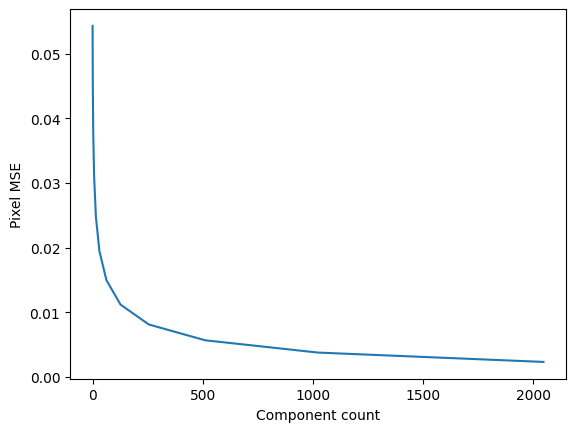

In [ ]:
# X axis is number of components.
plt.plot(components_subset, np.mean(mse, axis=0))
plt.xlabel("Component count")
plt.ylabel("Pixel MSE")

Text(0, 0.5, 'PSNR')

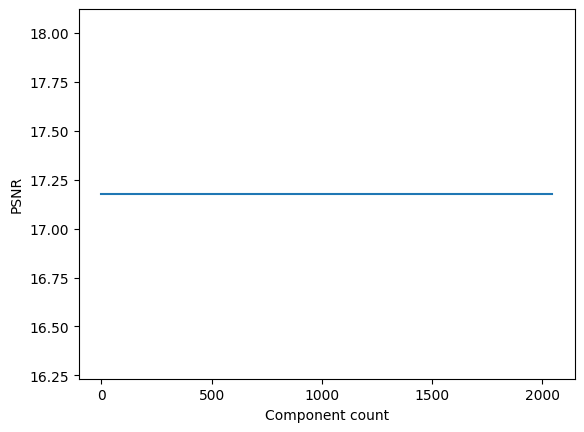

In [ ]:
plt.plot(components_subset, np.mean(psnr, axis=0))
plt.xlabel("Component count")
plt.ylabel("PSNR")

Text(0, 0.5, 'SSIM')

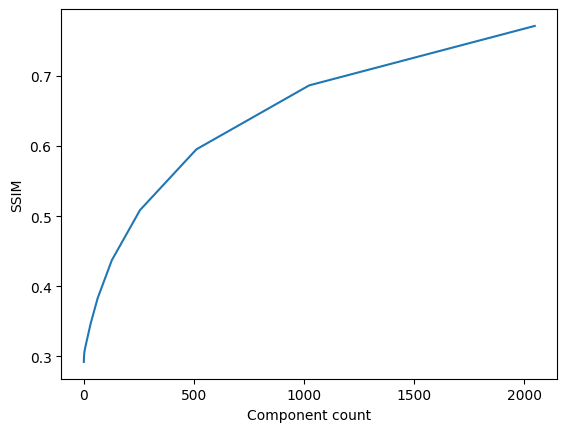

In [ ]:
plt.plot(components_subset, np.mean(ssim, axis=0))
plt.xlabel("Component count")
plt.ylabel("SSIM")